## Step 1: Load the newsgroups data

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. You can find additional information here:

In [11]:
!pip install hdbscan
!pip install numpy==1.24
!pip install umap-learn
!pip install matplotlib
!pip install pandas
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039183 sha256=3205a060c9220103d53cc6638fd995b12eba65d3736f41e370c2e71f5c9090cd
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.5
    Uninstalling Cython-3.0.5:
      Successfully uninstalled Cython-3.0.5


In [2]:
from sklearn.datasets import fetch_20newsgroups

# You can load just a subset of categories for simplicity
categories = ['talk.religion.misc','alt.atheism','soc.religion.christian']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")

From: jayne@mmalt.guild.org (Jayne Kulikauskas)
Subject: Re: Can sin "block" our prayers?
Organization: Kulikauskas home
Lines: 27

mike@boulder.snsc.unr.edu (Mike McCormick) writes:

> Not honoring our wives can cause our prayers to be hindered:
> 
>         You husbands likewise, live with your wives in
>         an understanding way, as with a weaker vessel,
>         since she is a woman;  and grant her honor as
>         a fellow heir of the grace of life, so that your
>         prayers may not be hindered.  I Peter 3:7

One interpretation I've heard of this verse is that it refers to the sin 
of physically abusing one's wife.  The husband is usually physically 
stronger than his wife but is not permitted to use this to dominate her.  
He must honor her as his sister in Christ.  This would therefore be an 
example of a specific sin that blocks prayer.

This verse also makes me think of the kind of husband who decides what 
is God's will for his family without consulting his wife. 

## Step 2:  Vectorize our data

We need to turn our text into sets of words.  However, we don't want words that are either too frequent or infrequent.  To do this, we'll use the TF-IDF vectorizer, and pick the top N (up to you!) words.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Sample data
documents = newsgroups_train.data

# Initialize the TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit the model and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

print(vectorizer)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each feature
# Here, we sum the scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connecting term to its sums score
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0,col]))

# Create a DataFrame with the terms and their scores
ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

# Select top N terms
top_n = 1000
top_n_terms = ranking.head(top_n)
print(top_n_terms)

TfidfVectorizer(stop_words='english')
            term       rank
8230         edu  54.141299
10292        god  50.703659
5671         com  36.943917
16372     people  31.206464
12551      jesus  27.993130
...          ...        ...
8898    examples   2.508613
18289    related   2.506292
17433   prophets   2.501462
9648   followers   2.498626
8576    entirely   2.497467

[1000 rows x 2 columns]


## Step 3: Join your terms with the Glove Vectors

The GLOVE vectors are word embeddings produced by the Word2Vec network model.  You can find them at the [Stanford GloVe repository](https://nlp.stanford.edu/projects/glove/).  You'll probably want the smallest one (glove6b).  Once you have them, you'll need to map these vectors to your data - note that the vectors come in different sizes.  I'll use the 100 dimension vectors here for demonstration purposes.

In [4]:
import numpy as np

# Load GloVe vectors into a dictionary:
glove_vectors = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

In [5]:
original_feature_names = top_n_terms.term

#Note that not all features are present in the glove vectors, so we'll filter here:
word_vectors = []
filtered_feature_names = []

for word in original_feature_names:
    if word in glove_vectors:
        word_vectors.append(glove_vectors[word])
        filtered_feature_names.append(word)

# Convert the list of vectors to a numpy array
word_vectors = np.array(word_vectors)
word_vectors_df = pd.DataFrame(word_vectors)
word_vectors

array([[ 0.052258,  0.1337  , -0.13601 , ..., -0.24305 , -0.71567 ,
        -0.42782 ],
       [ 0.43414 ,  0.83408 ,  0.5934  , ..., -0.58435 ,  0.084958,
         0.26176 ],
       [-0.94352 ,  0.18712 ,  0.3666  , ..., -0.11644 , -0.47114 ,
        -0.40741 ],
       ...,
       [ 0.57124 ,  0.11908 ,  0.34778 , ..., -0.31196 , -0.40189 ,
         0.25995 ],
       [ 0.69878 ,  0.060194, -0.5544  , ..., -0.30521 ,  0.21194 ,
         0.30873 ],
       [-0.48559 ,  0.23338 ,  0.46968 , ..., -0.25676 ,  0.20991 ,
        -0.19288 ]], dtype=float32)

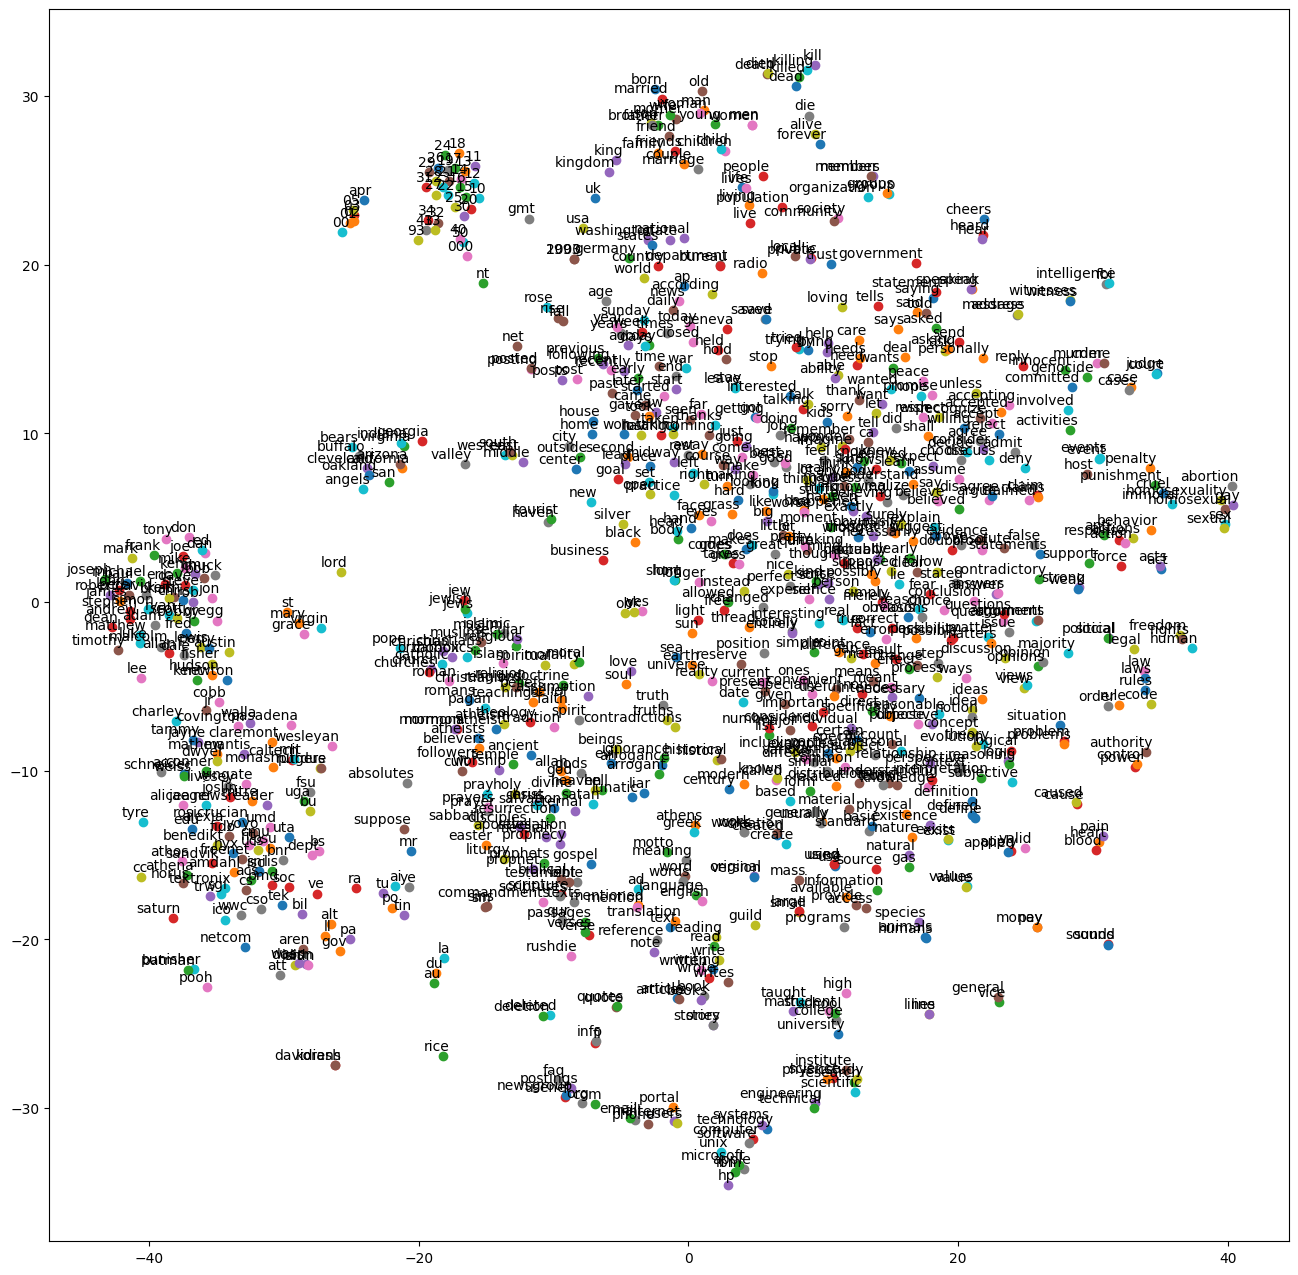

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE to project the vectors into a 2D space
tsne = TSNE(n_components=2)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()

UMAP(init='random', n_neighbors=30, spread=2, verbose=True)
Wed Nov 15 21:41:40 2023 Construct fuzzy simplicial set
Wed Nov 15 21:41:41 2023 Finding Nearest Neighbors
Wed Nov 15 21:41:45 2023 Finished Nearest Neighbor Search
Wed Nov 15 21:41:49 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Nov 15 21:41:54 2023 Finished embedding


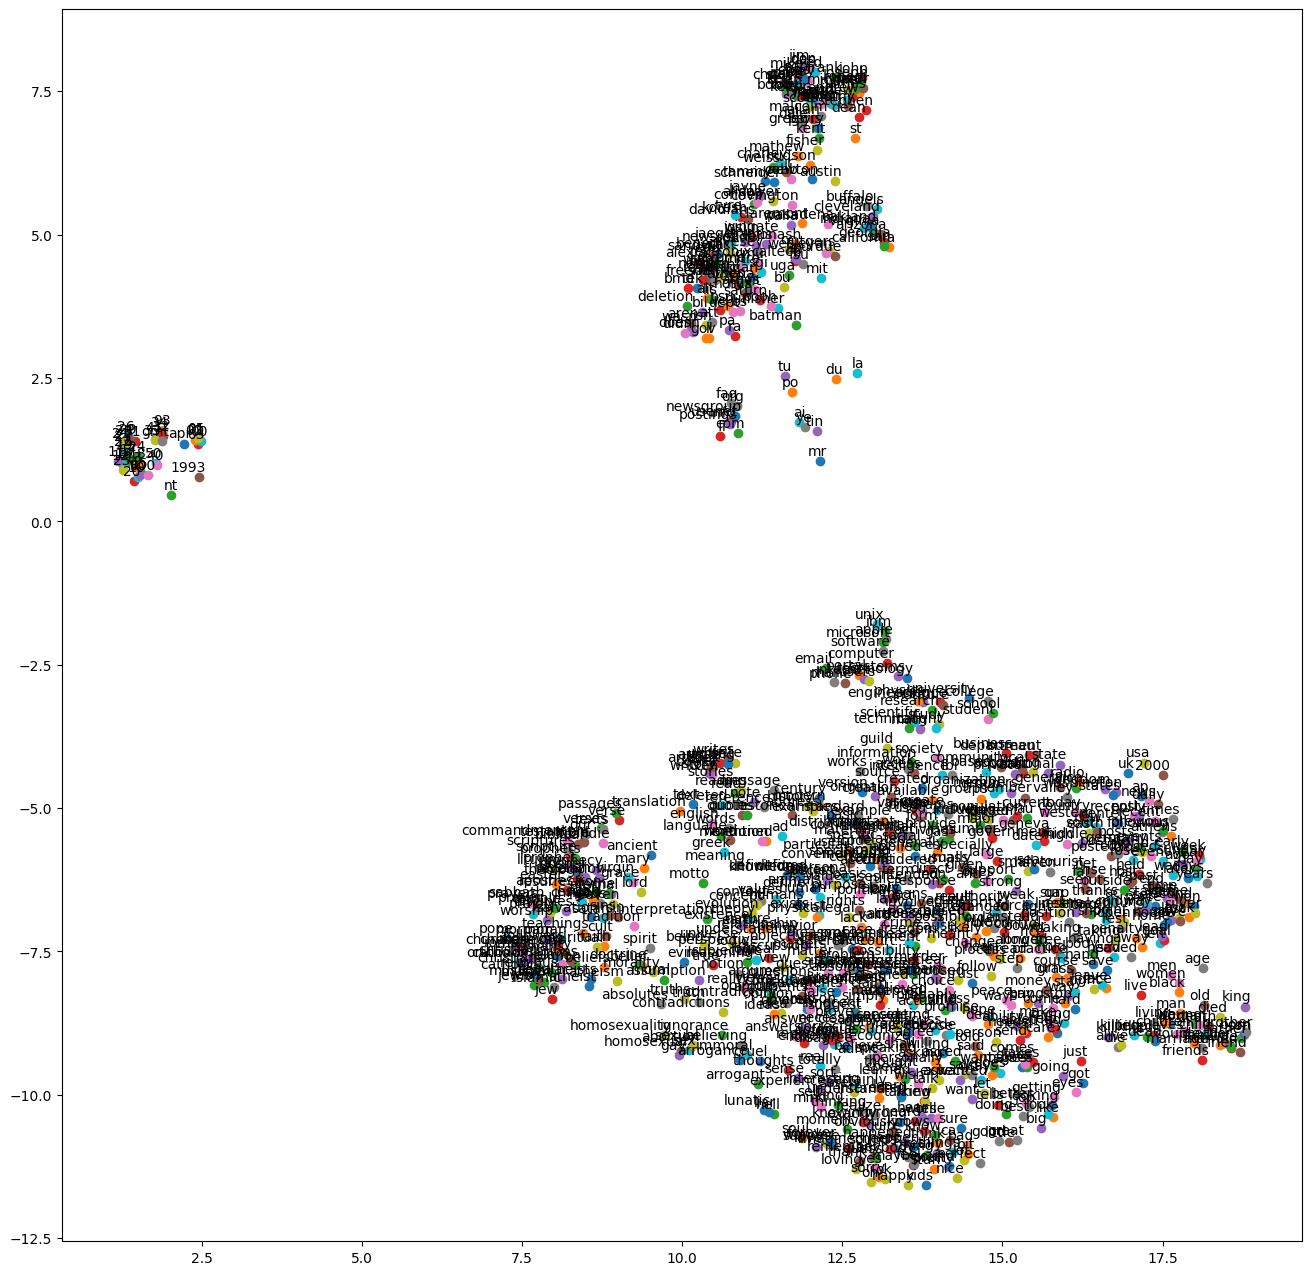

In [7]:
import matplotlib.pyplot as plt
import umap

# Use umap to project the vectors into a 2D space
umap = umap.UMAP(    init='random',
                    n_components=2,
                    n_neighbors=30,
                    min_dist=0.1,
                     spread=2,
                    metric='euclidean',
                    verbose=True)

word_vectors_df = pd.DataFrame(word_vectors)
word_vectors_umap = umap.fit_transform(word_vectors_df)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_umap[i, 0], word_vectors_umap[i, 1])
        plt.annotate(word, xy=(word_vectors_umap[i, 0], word_vectors_umap[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()

UMAP(init='random', n_neighbors=30, spread=2, verbose=True)
Wed Nov 15 21:44:01 2023 Construct fuzzy simplicial set
Wed Nov 15 21:44:04 2023 Finding Nearest Neighbors
Wed Nov 15 21:44:04 2023 Finished Nearest Neighbor Search
Wed Nov 15 21:44:04 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Nov 15 21:44:14 2023 Finished embedding


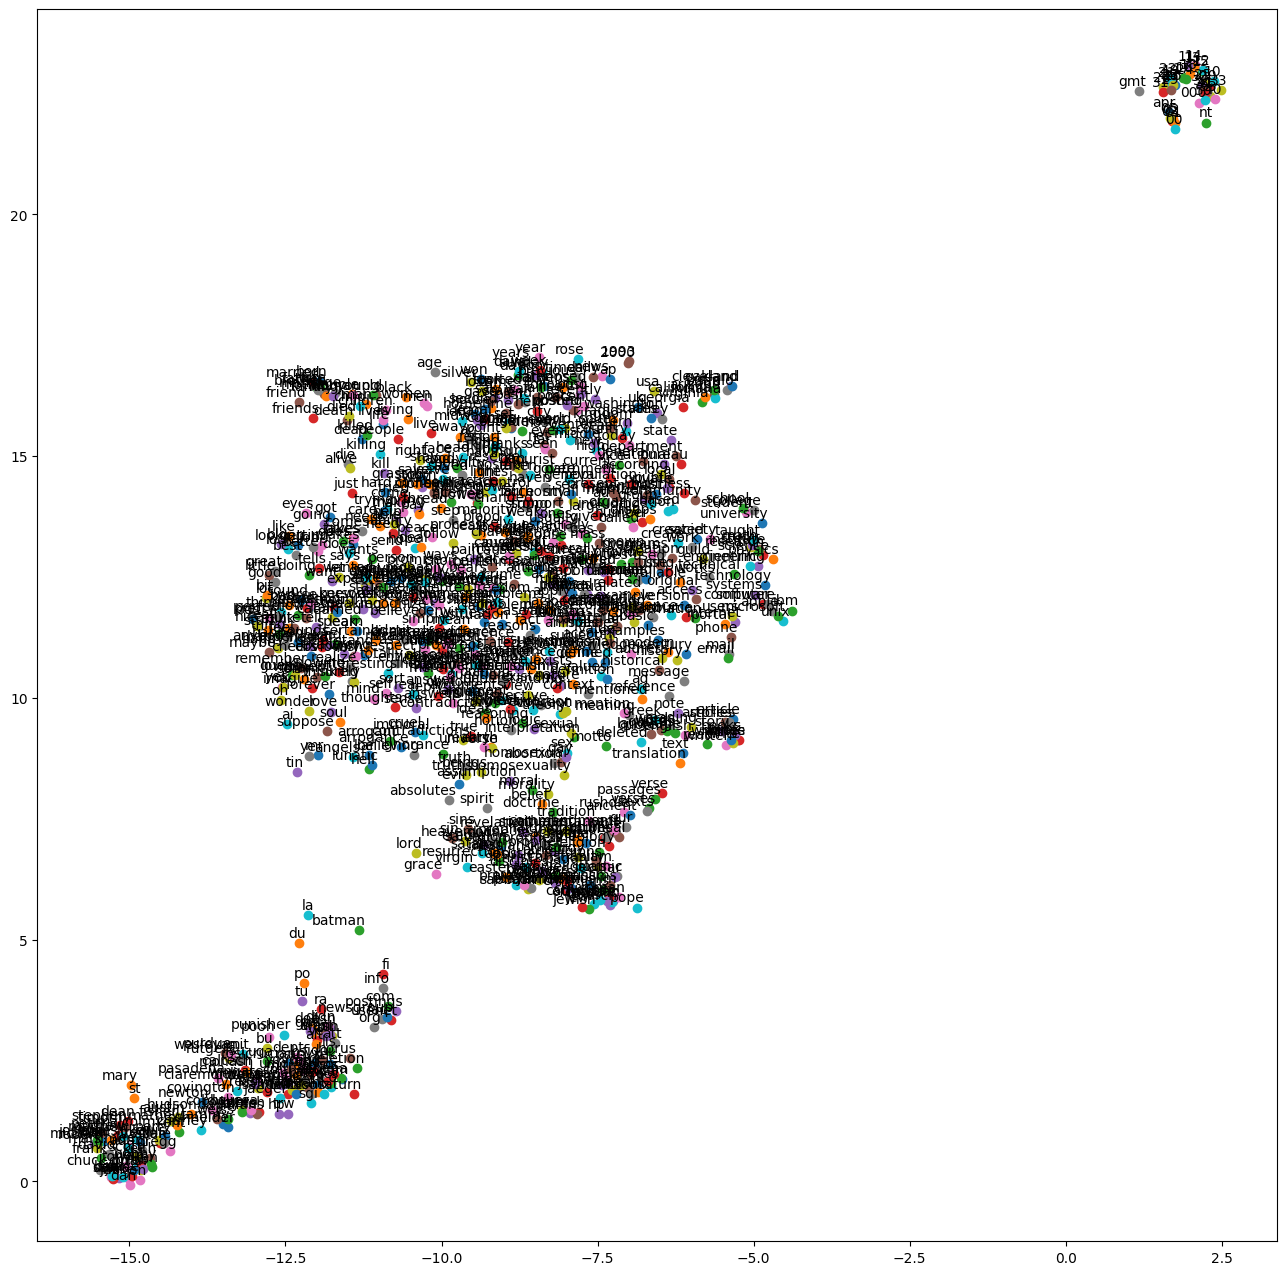

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Apply KMeans clustering - Method 1
kmeans = KMeans(n_clusters=5,n_init='auto')
kmeans.fit_transform(word_vectors_df)
labels = kmeans.labels_

# Use umap to project the clustered vector points into a 2D space - Method 1
word_vectors_umap = umap.fit_transform(word_vectors_df)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_umap[i, 0], word_vectors_umap[i, 1])
        plt.annotate(word, xy=(word_vectors_umap[i, 0], word_vectors_umap[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()


UMAP(init='random', n_neighbors=30, spread=2, verbose=True)
Wed Nov 15 21:54:31 2023 Construct fuzzy simplicial set
Wed Nov 15 21:54:32 2023 Finding Nearest Neighbors
Wed Nov 15 21:54:32 2023 Finished Nearest Neighbor Search
Wed Nov 15 21:54:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Nov 15 21:54:43 2023 Finished embedding


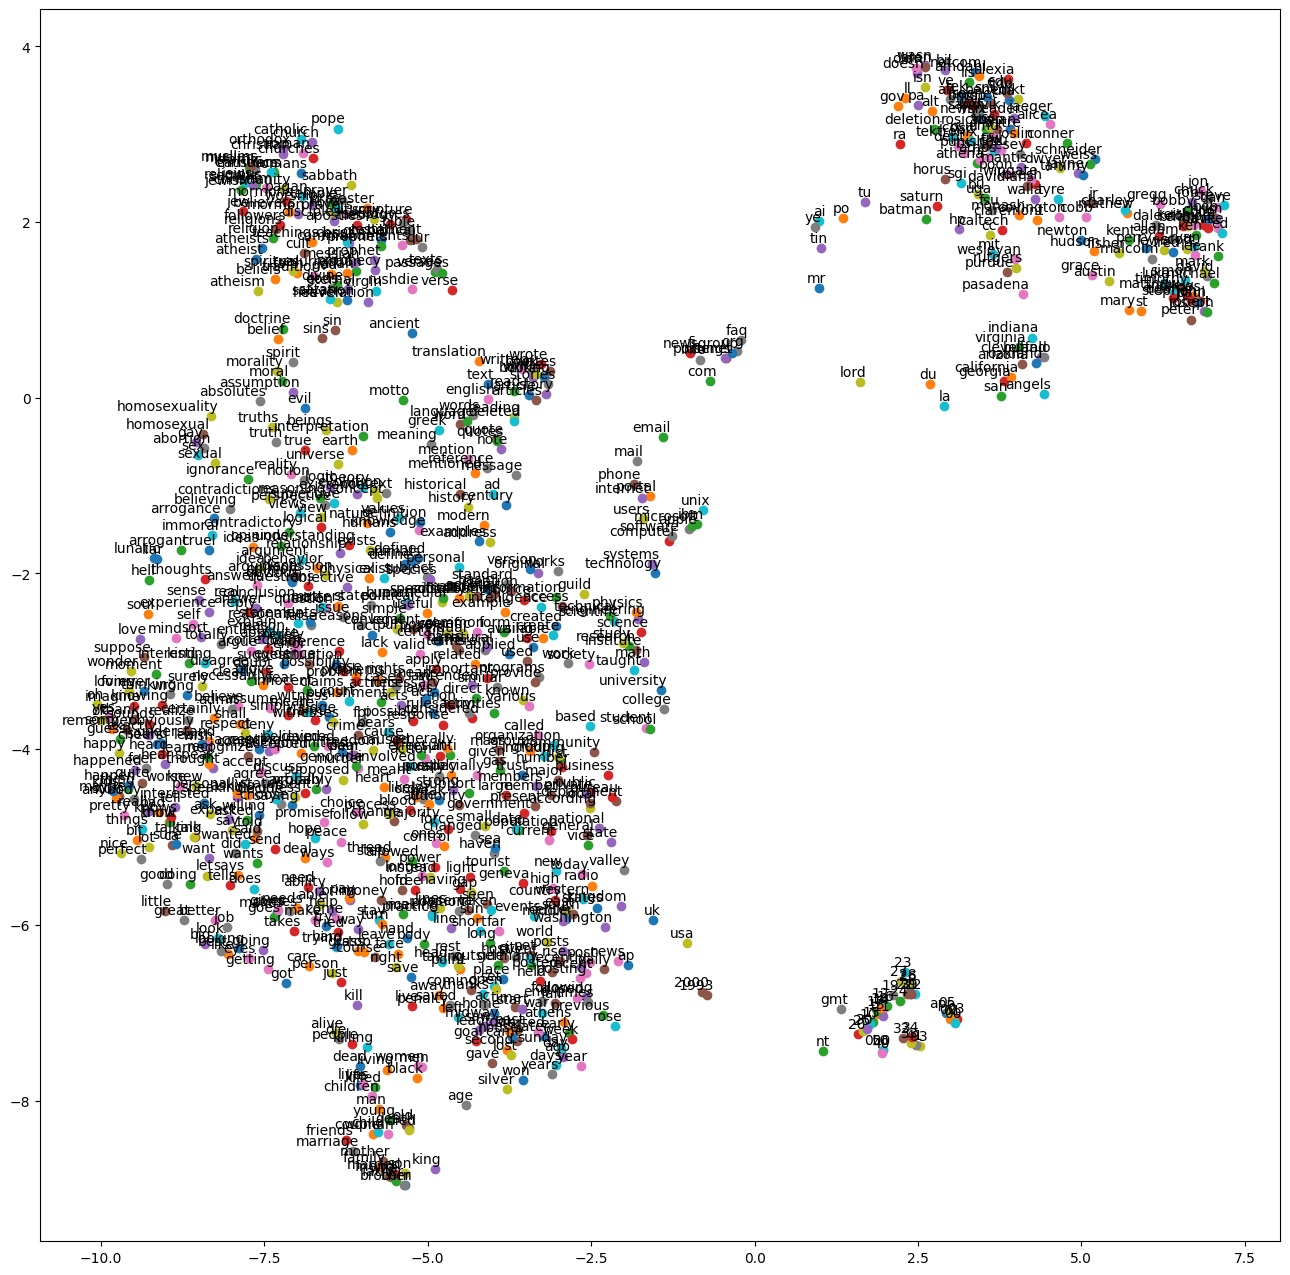

In [13]:
import hdbscan

# Apply HDBScan clustering - Method 2
hdbscan = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=30).fit_predict(word_vectors_df)

# Use umap to project the clustered vector points into a 2D space - Method 1
word_vectors_umap = umap.fit_transform(word_vectors_df)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_umap[i, 0], word_vectors_umap[i, 1])
        plt.annotate(word, xy=(word_vectors_umap[i, 0], word_vectors_umap[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()

1. Not clustering the data before projecting it looks good, except its difficult to tell the actual level of relation between the words due to clutter and overlap. Projecting the data after clustering makes the clusters not only clearer to interpret, but they also have more substantial meaning.

2. In the HDBScan clustering and Umap dimensionality reduction, there's a cluster that sorts out a lot of religious terms like pope and the denominations of Christianity. The athiesm newsgroup also got clustered there as well, unsurprisingly, as they are diametrically opposed. There's another cluster that sorts through what are clearly miscellaneous religious names and a small nearby cluster that has state names specifically. All teh numbers that are referred to in the newsgroups are sorted off in their own isolated cluster as well.

3. All of these newsgroups are associated with religion, Christianity being the particular focus. After a google search to see the origins of newsgroups as a whole, I found that these orignated from Usenet, which is a reflection of the times from which these words were scraped; maybe if we recollected data modernly, the results would be less clustered due to the spread of information and modern religious schools of thought being more flexible. The primary differences between these newsgroups are the tone of the content: alt.atheism is more critical of religion, specifically Christianity, soc.religion.christian is very exploratory and ventures to interpret the lessons of Christianity in a large variety of ways, while talk.religion.misc draws on miscellaneous conversations regarding Christianity whether they be Bible verse discussion or personal anecdotes relating to the church.

In [14]:
categories

['talk.religion.misc', 'alt.atheism', 'soc.religion.christian']